In [2]:

# TODO(developer): Set table_id to the ID of the table to create.
# table_id = "your-project.your_dataset.your_table_name"
table_id='newsci-1532356874110.divvyup_metadata.reconciliation_output'
schema = [
    bigquery.SchemaField("key", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("simple_crop", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("final_crop", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("rec_1", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("rec_2", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("rec_3", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("rec_4", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("rec_5", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("angle_1", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("angle_2", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("angle_3", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("angle_4", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("angle_5", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("distance_1", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("distance_2", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("distance_3", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("distance_4", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("distance_5", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("ratio_1", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("ratio_2", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("ratio_3", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("ratio_4", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("ratio_5", "FLOAT", mode="NULLABLE")
]

table = bigquery.Table(table_id, schema=schema)
table = queryclient.create_table(table)  # Make an API request.
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table newsci-1532356874110.divvyup_metadata.reconciliation_output


In [57]:
np.array(Image.open('a.png')).shape

(350, 300, 3)

In [55]:
from skimage.transform import rescale, resize, rotate
a = np.ones((350,300,4))
b=a.resize((351,301))
b.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [61]:
sample = np.ones((100,200))
sample.resize((100,200))
sample.shape

(100, 200)

In [1]:
from PIL import Image
import numpy as np
import os
import json
import io
from google.cloud import logging, storage, vision, bigquery
from pathlib import Path
import tempfile
from skimage import img_as_ubyte
from skimage.transform import rescale, resize, rotate
import cv2
import importlib
#import utils
#importlib.reload(utils)
#%matplotlib inline
#import matplotlib.pyplot as plt
import pdb
import time
import math
from utils import detector
import importlib
importlib.reload(detector)
import torch
import torchvision.transforms as transforms
from utils.particle_swarm import RandomSearch


my_file = Path("/home/ericd/storagekey.json")
if my_file.is_file():
    storage_client = storage.Client.from_service_account_json(my_file)
    queryclient = bigquery.Client.from_service_account_json("/home/ericd/bqkey.json")
else:
    storage_client = storage.Client()
    queryclient = bigquery.Client()

In [ ]:


dataset_id = 'divvyup_metadata'  # replace with your dataset ID
table_id = 'reconciliation_output'  # replace with your table ID
table_ref = queryclient.dataset(dataset_id).table(table_id)
table = queryclient.get_table(table_ref)  # API request   
    
    
    
    
log_name = 'Reconciliation'
logging_client = logging.Client()
logger = logging_client.logger(log_name)
vision_client = vision.ImageAnnotatorClient()


In [ ]:

def npcosines(Original, Proposal):
    if Original.shape!= (350, 300, 4):
        Original = Original[:350,:300,:4]
    if Proposal.shape!= (350, 300, 4):
        Proposal = Proposal[:350,:300,:4]
    RGB_A = Original[:,:,:3]
    RGB_B = Proposal[:,:,:3]
    M_A = Original[:,:,3]
    M_B = Proposal[:,:,3]
    A = np.einsum('ijk,ij->ijk', RGB_A, M_A)
    B = np.einsum('ijk,ij->ijk', RGB_B, M_B)
    n_A = np.sqrt(np.einsum('ijk,ijk->ij', A, A))
    n_B = np.sqrt(np.einsum('ijk,ijk->ij', B, B))
    n = np.einsum('ij,ij->ij', n_A, n_B)
    C = np.einsum('ijk,ijk->ij', A, B)
    Sol = np.divide(C, n)
    Sol[np.isinf(Sol)]=0
    Sol[np.isnan(Sol)]=0
    return np.average(Sol,weights=M_A/255)

def get_angle2(eyes):
    eye1 = eyes['left_eye']
    eye2 = eyes['right_eye']
    eye1_l, eye1_r = eye1
    eye2_l, eye2_r = eye2
    eye1_l=float(eye1_l)
    eye1_r=float(eye1_r)
    eye2_l=float(eye2_l)
    eye2_r=float(eye2_r)
    
    if eye1_l == eye2_l:
        if eye1_r > eye2_r:
            angle = -90
        elif eye1_r < eye2_r:
            angle = 90
        else:
            angle = 0
    else:
        angle = math.atan((eye2_r-eye1_r)/(eye2_l-eye1_l))* (180 / math.pi)
    return -angle
        
def minimum_bounding_box(img,alpha=1,mode=0):
    """ Calculates the minimum bounding box for an image """
    yproj = img.mean(axis=1)
    xproj = img.mean(axis=0)
    if mode == 0:
    	_get_idx = lambda x: np.where(x>alpha)[0]
    else:
    	_get_idx = lambda x: np.where(x<alpha)[0]

    def _get_bounds_on_proj(proj):
        idx = _get_idx(proj)
        return(idx[0],
               idx[-1])

    x1,x2 = _get_bounds_on_proj(xproj)
    y1,y2 = _get_bounds_on_proj(yproj)
    return([y1,x1,y2,x2])

def crop_img_from_bbox(img,bbox):
    y1,x1,y2,x2 = bbox
    return(img[y1:y2,x1:x2])

def get_angle(eye1, eye2, nose):
    '''Getting the angle to rotate the images: Rotation Correction algorithm'''
    v = eye2 - eye1
    m = v[1] / v[0]
    xs = (nose[0] + nose[1] * m - eye1[1] * m + eye1[0] * m * m) / (1 + m * m)
    ys = m * (xs - eye1[0]) + eye1[1]
    vec = nose - np.array([xs, ys])
    angle = np.arctan2(- vec[1], vec[0]) * (180 / np.pi) + 90
    angle = 360 + angle if angle < 0 else angle
    return angle


def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)


def downloadBlob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    """TODO: Consider speeding this up by streaming to buffer"""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    logger.log_text(f"{source_blob_name} downloaded to  {destination_file_name}")


def MessageToJsonFacialLandmarks(response_fl):
    face_list = []
    for face in response_fl.face_annotations:

        bounding_poly_vertices = []
        for v in face.bounding_poly.vertices:
            bounding_poly_vertices.append({"x": v.x, "y": v.y})

        fd_bounding_poly_vertices = []
        for v in face.fd_bounding_poly.vertices:
            fd_bounding_poly_vertices.append({"x": v.x, "y": v.y})

        landmarks = {}
        unknown_count = 1
        for landmark in face.landmarks:
            t = landmark.type
            if t == 0:
                t = f"unknown{unknown_count}"
                unknown_count += 1
            landmarks[t] = {"x": landmark.position.x,
                            "y": landmark.position.y,
                            "z": landmark.position.z}
        face_dict = {}
        face_dict["bounding_poly_vertices"] = bounding_poly_vertices
        face_dict["fd_bounding_poly_vertices"] = fd_bounding_poly_vertices
        face_dict["landmarks"] = landmarks
        face_dict["roll_angle"] = face.roll_angle  # John
        face_dict["pan_angle"] = face.pan_angle
        face_dict["tilt_angle"] = face.tilt_angle
        face_dict["detection_confidence"] = face.detection_confidence
        face_dict["landmarking_confidence"] = face.landmarking_confidence
        face_dict["joy_likelihood"] = face.joy_likelihood
        face_dict["sorrow_likelihood"] = face.sorrow_likelihood
        face_dict["anger_likelihood"] = face.anger_likelihood
        face_dict["surprise_likelihood"] = face.surprise_likelihood
        face_dict["under_exposed_likelihood"] = face.under_exposed_likelihood
        face_dict["blurred_likelihood"] = face.blurred_likelihood
        face_dict["headwear_likelihood"] = face.headwear_likelihood
        face_list.append(face_dict)
    return face_list


def APIHumanLandmarks(input_image):
    """ Calls G object recognition for obtaining facial landmarks"""
    # Opening the original image, correcting the orientation, and cropping it
    try:
        cropped_image = input_image.copy()
    except Exception as e:
        logger.log_text(f"Image corrupted/preprocess failed {str(e)} ", severity='ERROR')
        return None, None#, None, None

    b = io.BytesIO()
    cropped_image.save(b, format='PNG')
    b = b.getvalue()

    try:
        response_fl = vision_client.annotate_image({'image': {'content': b}, 'features': [{'type': vision.enums.Feature.Type.FACE_DETECTION}, ], })
    except Exception as e:
        logger.log_text(f"Problem getting API response: {str(e)}", severity='ERROR')
        return None, None#, None, None

    #try:
    #    human_landmarks = MessageToJsonFacialLandmarks(response_fl)
    #except Exception as e:
    #    logger.log_text(f"Problem building json file: {str(e)}", severity='ERROR')
    #    return None, None, None, None

    try:
        left_eye = (response_fl.face_annotations[0].landmarks[0].position.x,
                    response_fl.face_annotations[0].landmarks[0].position.y)
        right_eye = (response_fl.face_annotations[0].landmarks[1].position.x,
                     response_fl.face_annotations[0].landmarks[1].position.y)

        nose = (response_fl.face_annotations[0].landmarks[7].position.x,
                response_fl.face_annotations[0].landmarks[7].position.y)

        eyes = left_eye, right_eye
        
        angle = get_angle(np.array([left_eye[0], left_eye[1]]),
                          np.array([right_eye[0], right_eye[1]]),
                          np.array([nose[0], nose[1]]))
        #print(angle)  # john

        angle = round(angle % 360, 2)
        angle2 = get_angle2({'left_eye':left_eye, 'right_eye':right_eye})
        print(angle,' angles',angle2 )

    except Exception as e:
        logger.log_text(f"Problem getting landmarks or angle: {str(e)}", severity='ERROR')
        return None, None#, None, None
    return angle,  eyes

    
def expanded_bb( final_points):
    # The function expects the height and width of an image (I called it cropped because 
    # I was working with simple crop, but any image), and then the "final points" was a 
    # 2-d array with the position of the landmarks (the first dimension were the y and 
    # the second dimension the x), and the scale parameters is because I increase the 
    # asmall bounding box by 15% (I am not sure you want to use it).
    # read the json/consider x0-x1 for all hat objects, take the max and compare/use the better distance
    left, right = final_points
    left_x, left_y = left
    right_x, right_y = right
    base_center_x = (left_x+right_x)/2
    base_center_y = (left_y+right_y)/2 
    dist_base = abs(complex(left_x, left_y)-complex(right_x, right_y ) )
    return (int(base_center_x), int(base_center_y) ), dist_base




def lap(image):
    #transforms image for cv2 to compute laplacian
    rgb_org_im = img_as_ubyte(image)     
    origin = np.float32(cv2.cvtColor(rgb_org_im, cv2.COLOR_BGR2GRAY))
    originL = cv2.Laplacian(origin, -1)
    return originL


def APIPetLandmarks(input_image,pet='dogs'):
    det = detector.Detector(False)
    trheechannel = input_image.copy()
    trheechannel = trheechannel.convert('RGB')
    eyes_dict = det.get_landmarks(im_files=trheechannel,subject_class=pet)#im_files, subject_class
    angle = get_angle2(eyes_dict)
    eyes = eyes_dict['left_eye'], eyes_dict['right_eye']
    return angle, eyes  

def exchangerbg(four_channel_img, trhee_channel_img, coord=None):
    mask2 = four_channel_img.copy()
    four_channel_img2=four_channel_img.copy()
    four_channel_img2.paste(trhee_channel_img, coord)#into 4 channel
    array_m = np.array(mask2)[:,:,3]
    array_b = np.array(four_channel_img2)
    array_b[:,:,3] = array_m
    final = Image.fromarray(array_b)
    return final  
    


def third_reconciliation(crop, mask):
    #X=crop, Y=underlying rbg from mask
    Y = mask.copy()
    X = crop.copy()
    X = X.convert('RGB')
    Y = Y.convert('RGB')
    model = RandomSearch(100,{'x':[-.15,.15],'y':[-.15,.15],'scale':[.65,1.3],'theta':[-10,10]},max_iters=50)
    X,Y = transforms.ToTensor()(X), transforms.ToTensor()(Y) #[:-1], transforms.ToTensor()(Y)[:-1]
    best,best_params = model(X,Y)
    T = model.transform(X,params=best_params)
    #print(T.size())
    tensor_to_pil = transforms.ToPILImage()(T)#.squeeze_(0))
    final_4 = exchangerbg(mask, tensor_to_pil)
    return final_4, best_params
    #X.permute(1,2,0)[.65,1.3
    
    
def second_reconciliation(file, mask_dict, detailed = False):
    #from file we use the  rbg, mask comes from mask dict
    mask = np.array(mask_dict['image']).copy()    
    crop = np.array(file).copy()
    l_crop = lap(crop[:,:,:3]) #the underlying rbg we want to improve
    min_bbox = minimum_bounding_box( mask[:,:,3], alpha=0, mode=0) #([y1,x1,y2,x2])#at this moment I also know the center of both images
    mask_crop = crop_img_from_bbox( mask, min_bbox).copy()
    l_mask = lap(mask_crop[:,:,:3])*mask_crop[:,:,3]
    newdict = {'lap_crop':l_crop,'lap_mask':l_mask,'detailed':detailed}
    rec, ratio, theta = get_filter_weights( newdict, file, mask_dict, min_bbox)
    return rec, ratio, theta
   

def get_filter_weights(laplacians, file, mask_dict,  min_bbox):
    #we take the original image, 
    #we multiply by the mask and we crop, 
    #then we use convolution on the target image.
    center = complex(mask_dict['center'][0], mask_dict['center'][1])
    image = laplacians['lap_crop'].copy()
    target = laplacians['lap_mask'].copy()
    detailed = laplacians['detailed']
    if detailed:
        resizing_range = range(-40, 40)
        rotating_range = range(-25, 25)
    else:
        resizing_range = range(-30, 30)
        rotating_range = range(-20,20)
    
        
    h_im = 350
    w_im = 300
    vector=[]
    y1,x1,y2,x2 = min_bbox
    conv_val = -900
    res = 0
    rot = 0
    results = None
    ncenter = center
    for i in resizing_range:
        resized_cropT = resize(image, (h_im+i,w_im+i), anti_aliasing=True)
        dcenter =complex(int(i*center.real/300), int(i*center.imag/350))
        new_center = center + dcenter
        for a in rotating_range:#default -10,10 with angle /20
            rot_cropT = rotate(resized_cropT/255, angle= a/40, center = (new_center.real, new_center.imag) )*255
            dx,dy = dcenter.real, dcenter.imag
            big_out = cv2.filter2D(rot_cropT, -1, target, anchor=(0,0))
            if big_out.shape[0]<target.shape[0]+1 or big_out.shape[1]<target.shape[1]+1:
                continue
            out = big_out[:-target.shape[0],:-target.shape[1]]
            maxmeasure = np.max(out)#np.max(outT[:-rot_cropT.shape[0],:-rot_cropT.shape[1]])
            if conv_val < maxmeasure:
                conv_val = maxmeasure
                res = i
                rot = a
                results = out
                ncenter = new_center
    
    l_m = laplacians['lap_mask'].copy()
    assert len(results)
    loc = np.where(results == conv_val)
    assert len(loc[0]) == 1
    Y1,X1,Y2,X2 =  (loc[0][0], loc[1][0],
                                    loc[0][0]+l_m.shape[0],
                                    loc[1][0]+l_m.shape[1])
    y1,x1,y2,x2 =  min_bbox #([y1,x1,y2,x2])
    pdb.set_trace()
    previous_prediction =  np.array(file.copy())[:,:,:3]#to resize as matrix, to rotate as matrix
    print(np.max(previous_prediction))
    resized = resize(previous_prediction, (h_im+res,w_im+res), anti_aliasing=True)
    pre_np = rotate(resized/255, angle= rot/40, center = (ncenter.real, ncenter.imag) )*255
    print(np.max(pre_np))
    
    mask = mask_dict['image'].copy()
    
    mask_np = np.array(mask)
    print(np.max(mask_np[:,:,:3]),np.max(mask_np[:,:,3]))
    mask_np[y1:y2,x1:x2,:3] = pre_np[Y1:Y2,X1:X2,:3]
    final = Image.fromarray(np.uint8(mask_np*255))
    return final, (h_im+res)/350, rot/40

def temp_pair2(im_dic):
    # [ {"key":,"key_m":,"bucket":,"mask":,"crop":,"classes":}]
    key, key_m,  bucket_name, source_blob_name_m, source_blob_name, classes = im_dic["key"], im_dic["key_m"], im_dic["bucket"], im_dic["mask"], im_dic["crop"], im_dic["classes"]
    return key, key_m, source_blob_name, source_blob_name_m, bucket_name, classes

def frame(crop_dict, base_dict):
    #current code: expands base, rotates crop
    #goal: expands and rotates crop, base untouch
    #base_left = (135,200) 
    #base_right =  (165,200)
    # we dont want to modify the mask, we can rescale the input image
    #Get (middle point of average eyes,  eyes' average distance) and (middle point of input image's eyes,  distance between input image's eyes).
    dx=0
    dy=0
    base_angle = base_dict['angle']
    base_left, base_right = base_dict['eyes']
    base_center_x, base_center_y = base_dict['center']
    base_center = complex(base_center_x, base_center_y)
    dist_base = base_dict['dist']
    mask = base_dict['image'].copy()
    h_base = mask.height #350
    w_base = mask.width  #300

    crop_left, crop_right = crop_dict['eyes']
    angle = crop_dict['angle']
    im_center_x, im_center_y = crop_dict['center']
    im_center = complex(im_center_x, im_center_y)
    dist_crop = crop_dict['dist']
    im = crop_dict['image'].copy()
    h_im = im.height
    w_im = im.width

    #first we resize the crop
    ratio = dist_crop/dist_base
    bigCrop = im.resize((int(w_im*ratio), int(h_im*ratio) ))
    #then we rotate it with center the middle of the eyes
    center = ( int(im_center_x*ratio),  int(im_center_y*ratio)  )
    im_r = bigCrop.rotate(base_angle-angle, center=center)# we may have to switch the angle
    #now we translate
    dcenter = base_center-im_center
    x_l = max(0, dcenter.real)-dcenter.real
    y_l = max(0, dcenter.imag)-dcenter.imag
    x_h = min(w_base, w_im +dcenter.real) - dcenter.real
    y_h = min(h_base, h_im +dcenter.imag) - dcenter.imag
    
    crop = im_r.crop(( int(x_l), int(y_l), int(x_h), int(y_h) ))#underlying rbg
    #then we glue under the mask
    #rbg crop, rgba mask, coord
    final = exchangerbg(mask, crop, (int(x_l + dcenter.real), int(y_l + dcenter.imag) ))
    
    return final, ratio



def first_reconciliation(input_image, input_image_m, key, tmp_labels, label='human'):
    #finds landmarks on both images and identify the images with those coordinates
    
    if label=='human':
        angle,  eyes = APIHumanLandmarks(input_image)
        angle_m, eyes_m = APIHumanLandmarks(input_image_m)
    else:
        angle,  eyes = APIPetLandmarks(input_image, label)
        angle_m, eyes_m = APIPetLandmarks(input_image_m, label)
    
    if not eyes or not eyes_m: 
        logger.log_text(f"Missing output on API Human Landmarks on {key}", severity='ERROR')
    im_center, dist_im = expanded_bb(  final_points=eyes)  #test
    im_center_m, dist_im_m = expanded_bb(  final_points=eyes_m)  #test
    crop_dict={'angle':angle, 'eyes':eyes, 'image':input_image,'center':im_center, 'dist':dist_im}
    mask_dict={'angle':angle_m, 'eyes':eyes_m, 'image':input_image_m,'center':im_center_m, 'dist':dist_im_m}
    file, ratio =  frame(crop_dict, mask_dict)
    dangle = angle_m-angle
    mask_dict['dangle'] = dangle
    mask_dict['ratio'] = ratio
    file.save(tmp_labels, 'png')
    return file,  mask_dict


def human_eyes(crop_image_path):
    # based on image it applies reconciliation    
    file = None
    human = True
    key, key_m, source_blob_name, source_blob_name_m, bucket_name,  classes =  temp_pair(crop_image_path)
    # [ {"key":,"key_m":,"bucket":,"mask":,"crop":,"classes":}]

    with tempfile.TemporaryDirectory() as tmpdirname:
        
        destination_blob_name = f'reconciliation_test/{key}/{key}'
        tmp_local_path_o = tmpdirname + '/' + key+'out.png'

        destination_blob_name_2 = f'reconciliation_test/{key}/{key}_2'
        tmp_local_path_o2 = tmpdirname + '/' + key+'out2.png'

        destination_blob_name_3 = f'reconciliation_test/{key}/{key}_3'
        tmp_local_path_o3 = tmpdirname + '/' + key+'out3.png'

        destination_blob_name_4 = f'reconciliation_test/{key}/{key}_4'
        tmp_local_path_o4 = tmpdirname + '/' + key+'out4.png'

        destination_blob_name_5 = f'reconciliation_test/{key}/{key}_5'
        tmp_local_path_o5 = tmpdirname + '/' + key+'out5.png'
        
        print('created temporary directory', tmpdirname)
        results = {'key' : key,
             'simple_crop':bucket_name+'/'+source_blob_name,
             'final_crop':bucket_name+'/'+source_blob_name_m}
        tmp_local_path = tmpdirname + '/' + key
        tmp_local_path_m = tmpdirname + '/' + key_m
        tmp_labels = tmpdirname + '/' + f'{key}_label'
        try:
            print(source_blob_name,bucket_name,source_blob_name_m)
            downloadBlob(bucket_name, source_blob_name, tmp_local_path)
            downloadBlob(bucket_name, source_blob_name_m, tmp_local_path_m)
        except Exception as e:
            print(str(e))
            logger.log_text(f"problem downloading image {str(e)} on {key}", severity='ERROR')
            return 'wrong input',None, None
        print('images downloaded')
        try:
            input_image = Image.open(tmp_local_path) #.convert('RGB')
            input_image_m = Image.open(tmp_local_path_m)
        except Exception as e:
            print(str(e))
            logger.log_text(f"Problem opening the image {str(e)} on {key}", severity='ERROR')
            return 'image corrupted'
        #class#'cats''dogs''''
        try:
            print('reconciling 1')
            #eyes
            startl = time.time()
            first_copy = input_image.copy().convert('RGB')
            file,  mask_dict  = first_reconciliation(first_copy, input_image_m, key, tmp_labels, classes)
            file.save(tmp_local_path_o)
            upload_blob('model_staging', tmp_local_path_o, destination_blob_name)#to determine 
            i_c = input_image_m.copy()
            o_c = file.copy()
            distance = npcosines(np.array(i_c), np.array(o_c) )
            results.update({'rec_1':'model_staging/'+destination_blob_name, 'distance_1':distance,'angle_1':mask_dict['dangle'], 'ratio_1':mask_dict['ratio'] })
            start2 = time.time()
            print(f'end of first reconciliation {start2-startl}')    
        except Exception as e:
            print(str(e))
            logger.log_text(f"Problem with first reconciliation {str(e)} on {key}", severity='ERROR')
        try:    
            print('reconciling 2')
            startl = time.time()
            firststep = file.copy().convert('RGB')
            mask_dict['image'] = input_image_m
            file_2, ratio_2, theta_2 =  second_reconciliation(firststep, mask_dict)
            file_2.save(tmp_local_path_o2)
            upload_blob('model_staging', tmp_local_path_o2, destination_blob_name_2)#to determine
            i_c2 = input_image_m.copy()
            o_c2 = file_2.copy()
            distance_2 = npcosines(np.array(i_c2), np.array(o_c2) )
            results.update({'rec_2':'model_staging/'+destination_blob_name_2, 'distance_2':distance_2,
                           'ratio_2':ratio_2, 'angle_2':theta_2})
            start2 = time.time()
            print(f'end of second reconciliation {start2-startl}')    
        except Exception as e:
            print(str(e))
            logger.log_text(f"Problem with second reconciliation {str(e)} on {key}", severity='ERROR')
        try:
            startl = time.time()
            print('reconciling 3')
            #old rec
            mask_dict['image'] = input_image_m
            second_copy = input_image.copy().convert('RGB')
            file_3, ratio_3, theta_3 = second_reconciliation(second_copy, mask_dict, detailed = True)#['image']
            file_3.save(tmp_local_path_o3)
            upload_blob('model_staging', tmp_local_path_o3, destination_blob_name_3)#to determine
            i_c3 = input_image_m.copy()
            o_c3 = file_3.copy()
            distance_3 = npcosines(np.array(i_c3), np.array(o_c3) )
            results.update({'rec_3':'model_staging/'+destination_blob_name_3, 'distance_3':distance_3,
                           'ratio_3':ratio_3, 'angle_3':theta_3})
            start2 = time.time()
            print(f'end of third reconciliation {start2-startl}') 
        except Exception as e:
            print(str(e))
            logger.log_text(f"Problem with third reconciliation {str(e)} on {key}", severity='ERROR')
        try:
            startl = time.time()
            print('reconciling 4')
            #luke
            third_copy = input_image.copy().convert('RGB')
            file_4, param = third_reconciliation(third_copy, input_image_m)
            file_4.save(tmp_local_path_o4)
            upload_blob('model_staging', tmp_local_path_o4, destination_blob_name_4)#to determine
            i_c4 = input_image_m.copy()
            o_c4 = file_4.copy()
            distance_4 = npcosines(np.array(i_c4), np.array(o_c4) )
            results.update({'rec_4':'model_staging/'+destination_blob_name_4, 'distance_4':distance_4,
                           'ratio_4':param[2].item(), 'angle_4':param[3].item()})
            start2 = time.time()
            print(f'end of forth reconciliation {start2-startl}') 
        except Exception as e:
            print(str(e))
            logger.log_text(f"Problem with four reconciliation {str(e)} on {key}", severity='ERROR')
        try:
            startl = time.time()
            print('reconciling 5')
            fourstep = file_4.copy().convert('RGB')
            mask_dict['image'] = input_image_m
            file_5, ratio_5, theta_5  =  second_reconciliation(fourstep, mask_dict)
            file_5.save(tmp_local_path_o5)
            upload_blob('model_staging', tmp_local_path_o5, destination_blob_name_5)#to determine
            i_c5 = input_image_m.copy()
            o_c5 = file_5.copy()
            distance_5 = npcosines(np.array(i_c5), np.array(o_c5) )
            results.update({'rec_5':'model_staging/'+destination_blob_name_5, 'distance_5':distance_5,
                           'ratio_5':ratio_5, 'angle_5':theta_5})
            start2 = time.time()
            print(f'end of forth reconciliation {start2-startl}') 
        except Exception as e:
            print(str(e))
            logger.log_text(f"Problem with fifth reconciliation {str(e)} on {key}", severity='ERROR')
            
            
        rows_to_insert = []
        print(results)
        rows_to_insert.append(results)
        errors = queryclient.insert_rows(table, rows_to_insert)  # API request
        if errors:
            print(f'errors{str(errors)}')
        print('querry submitted!')

    


def temp_pair(crop_image_path):
    # based on image it applies reconciliation    
    split_path = crop_image_path.split('/')
    try:
        key = split_path[-2]
        key_m = split_path[-2]+'m.png'
        bucket = split_path[0]
        source_blob_name = crop_image_path.replace(bucket + '/', '')
        source_blob_name_m = crop_image_path.replace(bucket + '/', '').replace('crop_of_subject', 'final')
    except Exception as e:
        logger.log_text(f"Wrong path structure {str(e)} on {crop_image_path}", severity='ERROR')
        return 'wrong input'
    return key, key_m, source_blob_name, source_blob_name_m, 'divvyup_store', 'human'
    
                    
if __name__ == "__main__":
    start = time.time()
    input_image_path = "divvyup_store/socks/600000/crop_of_subject"
    dataloader = input_image_path#this function queries a table and returns a pair of strings
    print('first process')
    human_eyes(dataloader)
    #print(firststep.size, secstep.size, thirdstep.size, fourstep.size,)
    end = time.time()
    print(f'Total time: {end - start}')

    

first process
created temporary directory /tmp/tmp5_4lsgsd
socks/600000/crop_of_subject divvyup_store socks/600000/final
images downloaded
reconciling 1
2.99  angles 2.9908687760354105
1.0  angles 0.9953377313519912


/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


end of first reconciliation 1.4138741493225098
reconciling 2
> <ipython-input-6-bb0dad8b5cbb>(323)get_filter_weights()
-> previous_prediction =  np.array(file.copy())[:,:,:3]#to resize as matrix, to rotate as matrix


(Pdb)  n


> <ipython-input-6-bb0dad8b5cbb>(324)get_filter_weights()
-> print(np.max(previous_prediction))


(Pdb)  n


255
> <ipython-input-6-bb0dad8b5cbb>(325)get_filter_weights()
-> resized = resize(previous_prediction, (h_im+res,w_im+res), anti_aliasing=True)


(Pdb)  n


> <ipython-input-6-bb0dad8b5cbb>(326)get_filter_weights()
-> pre_np = rotate(resized/255, angle= rot/40, center = (ncenter.real, ncenter.imag) )*255


(Pdb)  n


> <ipython-input-6-bb0dad8b5cbb>(327)get_filter_weights()
-> print(np.max(pre_np))


(Pdb)  n


1.0
> <ipython-input-6-bb0dad8b5cbb>(329)get_filter_weights()
-> mask = mask_dict['image'].copy()


(Pdb)  p no.max(resized)


*** NameError: name 'no' is not defined


(Pdb)  p np.max(resized)


1.0


(Pdb)  q



reconciling 3
> <ipython-input-6-bb0dad8b5cbb>(323)get_filter_weights()
-> previous_prediction =  np.array(file.copy())[:,:,:3]#to resize as matrix, to rotate as matrix


In [ ]:
 Y1,X1,Y2,X2 =  (loc[0][0], loc[1][0],
                                    loc[0][0]+l_m.shape[0],
                                    loc[1][0]+l_m.shape[1])
    y1,x1,y2,x2 =  min_bbox #([y1,x1,y2,x2])
    previous_prediction =  file.copy()#to resize as matrix, to rotate as matrix
    proposal_size = previous_prediction.resize((h_im+res,w_im+res))
    proposal_rot = proposal_size.rotate(rot/40, center=(ncenter.real, ncenter.imag))
    pre_np = np.array(proposal_rot)
    mask = mask_dict['image'].copy()
    
    mask_np = np.array(mask)
    mask_np[y1:y2,x1:x2,:3] = pre_np[Y1:Y2,X1:X2,:3]
    #print(np.max(mask_np), np.max(mask_np[:,:,:3]), np.max(mask_np[:,:,3]),np.min(mask_np[:,:,3]),np.mean(mask_np[:,:,3]))
    final = Image.fromarray(mask_np)
   

In [ ]:
import pdb
file = None
human = True
key, key_m, source_blob_name, source_blob_name_m, bucket_name,  classes =  temp_pair(input_image_path)
# [ {"key":,"key_m":,"bucket":,"mask":,"crop":,"classes":}]

with tempfile.TemporaryDirectory() as tmpdirname:

    destination_blob_name = f'reconciliation_test/{key}/{key}'
    tmp_local_path_o = tmpdirname + '/' + key+'out.png'

    destination_blob_name_2 = f'reconciliation_test/{key}/{key}_2'
    tmp_local_path_o2 = tmpdirname + '/' + key+'out2.png'

    destination_blob_name_3 = f'reconciliation_test/{key}/{key}_3'
    tmp_local_path_o3 = tmpdirname + '/' + key+'out3.png'

    destination_blob_name_4 = f'reconciliation_test/{key}/{key}_4'
    tmp_local_path_o4 = tmpdirname + '/' + key+'out4.png'

    destination_blob_name_5 = f'reconciliation_test/{key}/{key}_5'
    tmp_local_path_o5 = tmpdirname + '/' + key+'out5.png'

    print('created temporary directory', tmpdirname)
    results = {'key' : key,
         'simple_crop':bucket_name+'/'+source_blob_name,
         'final_crop':bucket_name+'/'+source_blob_name_m}
    tmp_local_path = tmpdirname + '/' + key
    tmp_local_path_m = tmpdirname + '/' + key_m
    tmp_labels = tmpdirname + '/' + f'{key}_label'
    try:
        print(source_blob_name,bucket_name,source_blob_name_m)
        downloadBlob(bucket_name, source_blob_name, tmp_local_path)
        downloadBlob(bucket_name, source_blob_name_m, tmp_local_path_m)
    except Exception as e:
        print(str(e))
        logger.log_text(f"problem downloading image {str(e)} on {key}", severity='ERROR')
        #return 'wrong input',None, None
    print('images downloaded')
    try:
        input_image = Image.open(tmp_local_path) #.convert('RGB')
        input_image_m = Image.open(tmp_local_path_m)
    except Exception as e:
        print(str(e))
        logger.log_text(f"Problem opening the image {str(e)} on {key}", severity='ERROR')
        #return 'image corrupted'
    #class#'cats''dogs''''
    try:
        print('reconciling 1')
        #we find location of eyes and put that into mask dict, file is the output file
        startl = time.time()
        file,  mask_dict  = first_reconciliation(input_image, input_image_m, key, tmp_labels, classes)
        file.save(tmp_local_path_o)
        upload_blob('model_staging', tmp_local_path_o, destination_blob_name)#to determine
        results.update({'rec_1':'model_staging/'+destination_blob_name})
        start2 = time.time()
        print(f'end of first reconciliation {start2-startl}')    
    except Exception as e:
        print(str(e))
        logger.log_text(f"Problem with first reconciliation {str(e)} on {key}", severity='ERROR')
    try:
        input_image_m.save('test/Here.png')
        startl = time.time()
        print('reconciling 4')
        file_4 = third_reconciliation(input_image, input_image_m)
        input_image_m.save('test/fear.png')
        file_4.save(tmp_local_path_o4)
        upload_blob('model_staging', tmp_local_path_o4, destination_blob_name_4)#to determine
        results['rec_4'] = 'model_staging/'+destination_blob_name_4
        start2 = time.time()
        print(f'end of forth reconciliation {start2-startl}') 
    except Exception as e:
        print(str(e))
        logger.log_text(f"Problem with four reconciliation {str(e)} on {key}", severity='ERROR')
    try:
        startl = time.time()
        print('reconciling 5')
        fourstep = file_4.copy()
        mask_dict['image'] = input_image_m
        mask_dict['image'].save('test/why.png')
        file_5 =  second_reconciliation(fourstep, mask_dict)
        file_5.save(tmp_local_path_o5)
        upload_blob('model_staging', tmp_local_path_o5, destination_blob_name_5)#to determine
        results['rec_5']='model_staging/'+destination_blob_name_5
        start2 = time.time()
        print(f'end of forth reconciliation {start2-startl}') 
    except Exception as e:
        print(str(e))
        logger.log_text(f"Problem with fifth reconciliation {str(e)} on {key}", severity='ERROR')

            
       

In [ ]:

    previous_prediction =  np.array(file.copy())[:,:,:3]#to resize as matrix, to rotate as matrix
    
    resized = resize(previous_prediction, (h_im+res,w_im+res), anti_aliasing=True)
    pre_np = rotate(resized/255, angle= rot/40, center = (ncenter.real, ncenter.imag) )*255
    mask = mask_dict['image'].copy()
    
    mask_np = np.array(mask)
    mask_np[y1:y2,x1:x2,:3] = pre_np[Y1:Y2,X1:X2,:3]
    final = Image.fromarray(mask_np)
    return final, (h_im+res)/350, rot/40


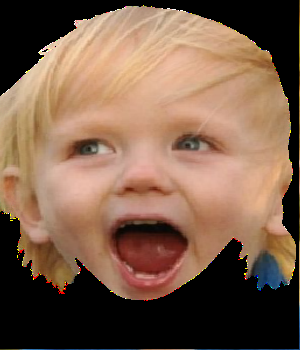

In [11]:
file_5

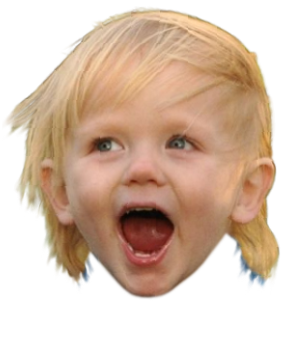

In [22]:
file

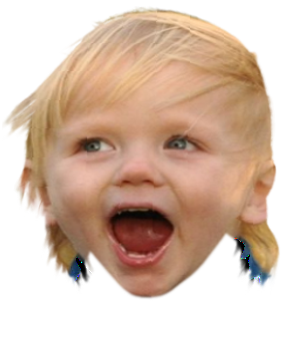

In [23]:
file_2

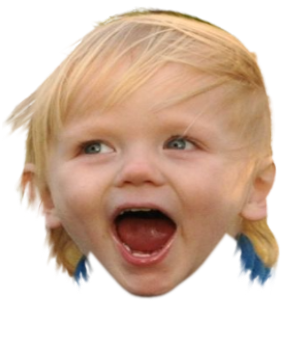

In [24]:

file_3

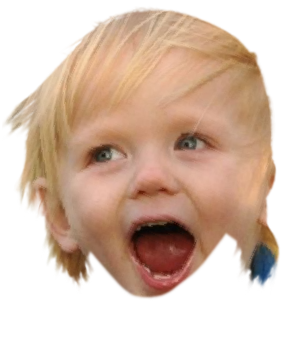

In [25]:
file_4

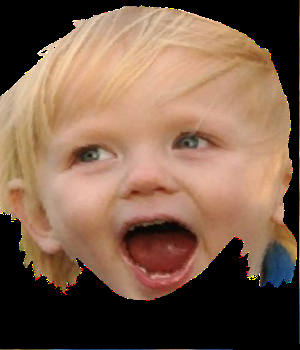

In [26]:
file_5

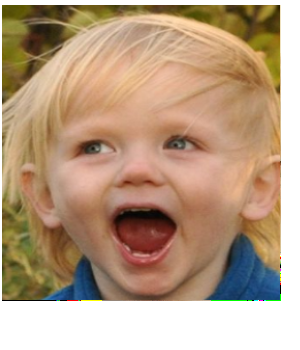

In [33]:
array_m = np.array(file_3)[:,:,:3]
Image.fromarray(array_m)

In [ ]:
Two cloud functions.


One that given a number parses the table, and calls another cloud function every 20 seconds.

A second that receives a dictionary and runs the algorithms.

In [6]:
import numpy as np
a = np.array([1,2,2])
b = np.array([2,4,4])
cosSim = a.dot(b)/((a.dot(a)*b.dot(b))**.5)
cosSim

1.0

In [10]:
A = np.ones((300,350,3))
B = 7*np.ones((300,350,3))
n_A = np.sqrt(np.einsum('ijk,ijk->ij', A,A))
n_B = np.sqrt(np.einsum('ijk,ijk->ij', B,B))
n = np.einsum('ij,ij->ij',n_A,n_B)
C = np.einsum('ijk,ijk->ij',A,B)
Sol = np.divide(C,n)
Sol[np.isinf(Sol)]=0
np.mean(Sol)

1.0

In [51]:
def cosinesimImages(Original, Proposal):
    if Original.shape!= (350, 300, 4):
        Original = Original[:350,:300,:4]
    if Proposal.shape!= (350, 300, 4):
        Proposal = Proposal[:350,:300,:4]
    RGB_A = Original[:,:,:3]
    RGB_B = Proposal[:,:,:3]
    M_A = Original[:,:,3]
    M_B = Proposal[:,:,3]
    A = np.einsum('ijk,ij->ijk', RGB_A, M_A)
    B = np.einsum('ijk,ij->ijk', RGB_B, M_B)
    n_A = np.sqrt(np.einsum('ijk,ijk->ij', A, A))
    n_B = np.sqrt(np.einsum('ijk,ijk->ij', B, B))
    n = np.einsum('ij,ij->ij', n_A, n_B)
    C = np.einsum('ijk,ijk->ij', A, B)
    Sol = np.divide(C, n)
    Sol[np.isinf(Sol)]=0
    Sol[np.isnan(Sol)]=0
    return np.average(Sol,weights=M_A/255)

In [54]:
from PIL import Image
pr = np.array(Image.open('c21.png'))
qr = np.array(Image.open('c22.png'))
cosinesimImages(pr,qr)

(350, 300) (350, 300)


/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


1.8773442792282637

In [19]:
A_.shape

(300, 350, 3)

In [20]:
A_

array([[[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       ...,

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]]])

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from google.cloud import storage
my_file = Path("/home/ericd/storagekey.json")
if my_file.is_file():
    storage_client = storage.Client.from_service_account_json(my_file)
else:
    storage_client = storage.Client()
bucket = storage_client.bucket('divvyup_data')

df = pd.read_csv("divvyup_cropped_subjects.csv")

num_rows, num_cols = df.shape

/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,orderId,orderProductId,croppedSubjectId,croppedSubjectKey,orderProductPhotoId,orderProductPhotoFilename,simpleCropId,simpleCropCategory,simpleCropErrorSendingForAutoCrop,simpleCropErrorSendingForAutoColor,simpleCropRotation,simpleCropScale,autoCropId,autoCropRating,autoCropKey,autoColorId,autoColorRating,autoColorKey
0,408599,337187,648631,408599/337187/cropped/69a47d79e971da5270ee2299...,465231,1569026971-97-0990b5f0-78b7-4dfd-b17d-b4b3312e...,1,other,0,0,\N,\N,\N,\N,\N,\N,\N,\N
1,408599,337188,648616,408599/337188/cropped/65755de0a59838f2175c6624...,465232,1569027012-95-f75a94df-5e8e-4a60-87a8-764177ab...,2,other,0,0,\N,\N,\N,\N,\N,\N,\N,\N
2,408599,337189,648823,408599/337189/cropped/b420b79d4d4a4ad8d069e933...,465233,1569027085-39-439c5a6d-a8f1-41c0-825f-3e258a54...,3,other,0,0,\N,\N,\N,\N,\N,\N,\N,\N
3,408636,337256,648399,408636/337256/cropped/b6664e9f5857bf66696ee650...,465327,1569088799-42-817cd4ce-6a5d-44c4-bc2e-37b9e08e...,4,face,0,0,\N,\N,1,1,auto_crops/7706d42ea876d614cf881f0cbed6576f.png,\N,\N,\N
4,408641,337264,648418,408641/337264/cropped/8a7b528ecb397379f9e9a1a2...,465341,1569092247-9-50a6e17f-e766-4d16-bd4f-ee4200c2f...,5,cat,0,0,\N,\N,2,1,auto_crops/c32941ba02f390d0bd71175196ca1eaf.png,\N,\N,\N


In [37]:
df.describe()

,orderId,orderProductId,croppedSubjectId,orderProductPhotoId,simpleCropId,simpleCropErrorSendingForAutoCrop,simpleCropErrorSendingForAutoColor
count,621257.000000,621257.000000,6.212570e+05,6.212570e+05,621257.000000,621257.000000,621257.000000
mean,617059.067853,596121.100932,1.110201e+06,7.858159e+05,337389.817232,0.003358,0.001655
std,121805.421271,150237.082259,2.726159e+05,1.843599e+05,193729.047009,0.057848,0.040644
min,408599.000000,337187.000000,6.483990e+05,4.652310e+05,1.000000,0.000000,0.000000
25%,508429.000000,464613.000000,8.799960e+05,6.270230e+05,170099.000000,0.000000,0.000000
50%,613231.000000,600441.000000,1.102776e+06,7.836800e+05,336929.000000,0.000000,0.000000
75%,729594.000000,726987.000000,1.321823e+06,9.464150e+05,506192.000000,0.000000,0.000000
max,843942.000000,863225.000000,1.641448e+06,1.108039e+06,672627.000000,1.000000,1.000000


In [51]:
simple_crop_blob[0].name

'843938/863217/cropped_simple/51b669d4335e9719345b79e697c103fe.png'

In [18]:
import pandas as pd
import numpy as np

from google.cloud import storage
my_file = Path("/home/ericd/storagekey.json")
if my_file.is_file():
    storage_client = storage.Client.from_service_account_json(my_file)
else:
    storage_client = storage.Client()
bucket = storage_client.bucket('divvyup_data')

df = pd.read_csv("divvyup_cropped_subjects.csv")

num_rows, num_cols = df.shape


bucket_read = storage_client.bucket('divvyup_store')


for row_num in np.arange(-80, -1):

    row = df.iloc[row_num]

    # Get the final image, i.e. what was printed on sock
    final_image_path = row['croppedSubjectKey']
    
    #final_image_blob = bucket.blob(final_image_path)
    #final_image_blob.download_to_filename("tmp_final.png")
    #final_image = Image.open("tmp_final.png")

    # Get the simple crop to reconcile with it
    simple_crop_blob = list(storage_client.list_blobs('divvyup_data',
        prefix=final_image_path[:final_image_path.index("cropped")]+'cropped_simple'))
    if len(simple_crop_blob) != 1:
        continue
    else:
        simple_crop_blob = simple_crop_blob[0]
        source_blob_name = f'socks/{row.simpleCropId}/crop_of_subject'
        # access metadata
        blob = bucket_read.get_blob(source_blob_name)
        if blob:
            metadata = blob.metadata
            if metadata['subjectType'] in ['dog', 'cat', 'face']:
                print(final_image_path, simple_crop_blob.name,'\n', metadata['subjectType'])
            else:
                print('other types of medatadat found are',metadata['subjectType'])
        else:
            #check for replacement of socks by socks, koozies and stickers
            print(f' files with id {row.simpleCropId} have no metadata and need to be sent to gcp:{final_image_path}, {simple_crop_blob.name}')
    #simple_crop_blob.download_to_filename("tmp_crop.png")
    #simple_crop = Image.open("tmp_crop.png")

    # reconcile(simple_crop, final_image)

/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


843798/863040/cropped/47fc1b83223838400ecae5c742a8f82f 843798/863040/cropped_simple/97910d0b3bd30834164253f9acd17738.png 
 face
843799/863041/cropped/78aa0f98f47d8b0e764c37eb21bd8da0 843799/863041/cropped_simple/33bd36c6a0378e005ac7f3049c05d722.png 
 face
843800/863043/cropped/aae1ee08768afda4721d96066664a241 843800/863043/cropped_simple/690523ec6658ff3e47be04f9dc093471.png 
 cat
843801/863044/cropped/5dd46fc44a42400ab3495a58cc4c9ab7 843801/863044/cropped_simple/e3796ce99686e1feee260701f35df2eb.png 
 face
843802/863045/cropped/7e8be9cf965430088fb66ec725a797b1 843802/863045/cropped_simple/6577dea391dd91630e6b9d31e51a8476.png 
 face
843804/863048/cropped/7cbf48d430f51cdf0f4ed13dc94d89f9 843804/863048/cropped_simple/8d4ad7f8368066f72083a3ef500f4c4c.png 
 dog
843806/863050/cropped/c69e30a2f51214ac0f9500b3ae79c163 843806/863050/cropped_simple/a097caf881548b09120c6e5290d9ff28.png 
 face
843811/863057/cropped/17de7610b705b1ef9c031a1981e4e21a 843811/863057/cropped_simple/944a222d3dfd652698ea7d

In [ ]:
f'divvyup_store/socks/{row.simpleCropId}/crop_of_subject'

In [12]:
bucket_name, source_blob_name = 'divvyup_store', f'socks/{672610}/crop_of_subject'
# access metadata
bucket = storage_client.bucket(bucket_name)
blob = bucket.get_blob(source_blob_name)
metadata = blob.metadata
metadata['subjectType']

'face'

In [13]:
from google.cloud import storage
storage_client = storage.Client()


'dog'

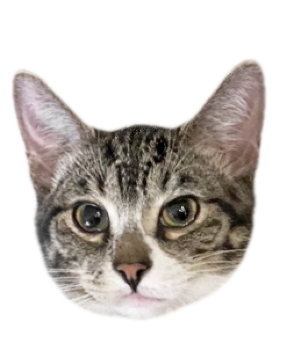

In [39]:
final_image

In [41]:
are they sending everything starting today or since the beginning?


2

In [ ]:

Table agreement:

    table two images and a class
    34
    what is the key?

    do we have now the final colored data? with class?
where do I store the reconciled images? 
    which bucket
    which table:
        what is the key?
        final iamge and the crops
        what are the rows
where does jeremy stores the user feedback?
    
    
    
    

In [ ]:
import pandas as pd
import numpy as np
from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.bucket('divvyup_data')

df = pd.read_csv("divvyup_cropped_subjects.csv")

num_rows, num_cols = df.shape

# Get last X% of the data
X = 0.50
beg_row = num_rows - int(num_rows*X)
end_row = num_rows
for row_num in np.arange(beg_row, end_row):

    row = df.iloc[row_num]

    # Get the final image, i.e. what was printed on sock
    final_image_path = row['croppedSubjectKey']
    final_image_blob = bucket.blob(final_image_path)
    final_image_blob.download_to_filename("tmp_final.png")
    final_image = Image.open("tmp_final.png")

    # Get the simple crop to reconcile with it
    simple_crop_blob = list(storage_client.list_blobs('divvyup_data',
        prefix=final_image_path[:final_image_path.index("cropped")]+'cropped_simple'))
    if len(simple_crop_blob) != 1:
        continue
    else:
        simple_crop_blob = simple_crop_blob[0]
    simple_crop_blob.download_to_filename("tmp_crop.png")
    simple_crop = Image.open("tmp_crop.png")

    # reconcile(simple_crop, final_image)

In [55]:
import os
os.system('gsutil cp gs://model_staging_dev/ML/ResNet50_Models /home/ericd/U-2-Net/utils/checkpoints')

256

/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


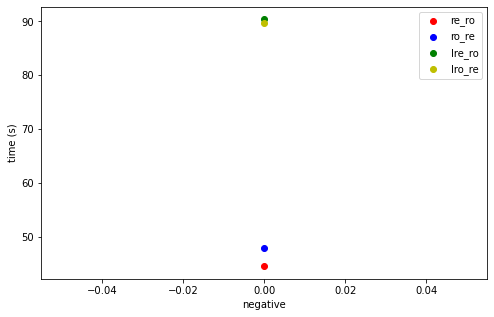

In [19]:
#Question: dilate vs rotate.
from skimage.transform import rescale, resize, rotate
from skimage.io import imread
%matplotlib inline
import matplotlib.pyplot as plt    
from timeit import Timer
def re_ro(image):
    h_im = 350
    w_im = 300 # making larger , making smaller first scale then rotate
    for i in range(30):
        resized_cropT = resize(image, (h_im-i,h_im-i), anti_aliasing=True)
        for a in range(-10,10):
            rot_cropT = rotate(resized_cropT/255, a/20 )*255
def lrero(image):
    h_im = 350
    w_im = 300
    [rotate(resize(image, (h_im-i,h_im-i), anti_aliasing=True)/255, a/20 )*255 for i in range(30) for a in range(-10,10)]
    
    
def ro_re(image):
    h_im = 350
    w_im = 300
    for a in range(-10,10):
        rot_cropT = rotate(image/255, a/20)*255    
        for i in range(30):
            resized_cropT = resize(rot_cropT, (h_im-i,h_im-i), anti_aliasing=True) 
def lrore(image):
    h_im = 350
    w_im = 300
    [resize(rotate(image, a/20 ), (h_im-i,h_im-i), anti_aliasing=True)/255*255 for a in range(-10,10) for i in range(30) ]
    
            
reps = 5
rd, dr, lrd, ldr = [], [], [], []
Ms = range(1)
output = imread("baby.png")
for _ in Ms:
    t = Timer(lambda: re_ro(output))
    rd.append(t.timeit(number=reps))
    t = Timer(lambda: ro_re(output))
    dr.append(t.timeit(number=reps))
    t = Timer(lambda: lrero(output))
    lrd.append(t.timeit(number=reps))
    t = Timer(lambda: lrore(output))
    ldr.append(t.timeit(number=reps))
    
fig , ax = plt.subplots(figsize=(8, 5))
ax.scatter(Ms, rd, c='r', label='re_ro')
ax.scatter(Ms, dr, c='b', label='ro_re')
ax.scatter(Ms, lrd, c='g', label='lre_ro')
ax.scatter(Ms, ldr, c='y', label='lro_re')
ax.set_xlabel('negative')
ax.set_ylabel('time (s)')
ax.legend();    

/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


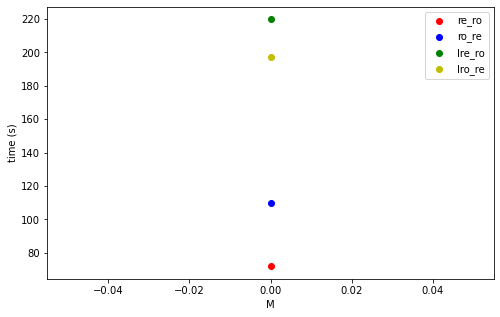

In [51]:
#Question: dilate vs rotate.
from skimage.transform import rescale, resize, rotate
from skimage.io import imread
%matplotlib inline
import matplotlib.pyplot as plt    
from timeit import Timer
def re_ro(image):
    h_im = 350
    w_im = 300 # making larger , making smaller first scale then rotate
    for i in range(30):
        resized_cropT = resize(image, (h_im+i,h_im+i), anti_aliasing=True)
        for a in range(-10,10):
            rot_cropT = rotate(resized_cropT/255, a/20 )*255
def lrero(image):
    h_im = 350
    w_im = 300
    [rotate(resize(image, (h_im+i,h_im+i), anti_aliasing=True)/255, a/20 )*255 for i in range(30) for a in range(-10,10)]
    
    
def ro_re(image):
    h_im = 350
    w_im = 300
    for a in range(-10,10):
        rot_cropT = rotate(image/255, a/20)*255    
        for i in range(30):
            resized_cropT = resize(rot_cropT, (h_im+i,h_im+i), anti_aliasing=True) 
def lrore(image):
    h_im = 350
    w_im = 300
    [resize(rotate(image, a/20 ), (h_im+i,h_im+i), anti_aliasing=True)/255*255 for a in range(-10,10) for i in range(30) ]
    
            
reps = 5
rd, dr, lrd, ldr = [], [], [], []
Ms = range(1)
output = imread("baby.png")
for _ in Ms:
    t = Timer(lambda: re_ro(output))
    rd.append(t.timeit(number=reps))
    t = Timer(lambda: ro_re(output))
    dr.append(t.timeit(number=reps))
    t = Timer(lambda: lrero(output))
    lrd.append(t.timeit(number=reps))
    t = Timer(lambda: lrore(output))
    ldr.append(t.timeit(number=reps))
    
fig , ax = plt.subplots(figsize=(8, 5))
ax.scatter(Ms, rd, c='r', label='re_ro')
ax.scatter(Ms, dr, c='b', label='ro_re')
ax.scatter(Ms, lrd, c='g', label='lre_ro')
ax.scatter(Ms, ldr, c='y', label='lro_re')
ax.set_xlabel('M')
ax.set_ylabel('time (s)')
ax.legend();    

In [52]:
print(rd, dr, lrd, ldr)

[71.81946012900153] [109.84010259599017] [219.7612666470086] [197.19490853499155]


In [ ]:
Given mask, we find a region round the head, using those coordinates, we crop on the output of rotation dilation and we only use convolution on that part

In [ ]:
#files mask, base
from skimage.transform import rescale, resize, rotate
from skimage import img_as_ubyte
from utils import minimum_bounding_box, crop_img_from_bbox
import cv2
def lap(image):
    rgb_org_im = img_as_ubyte(image)     
    origin = np.float32(cv2.cvtColor(rgb_org_im, cv2.COLOR_BGR2GRAY))
    origin_rows, origin_cols = origin.shape
    originL = cv2.Laplacian(origin, -1)
    return originL    
def get_filter_weights(image, center):
    h_im = 350
    w_im = 300
    vector=[]
    for i in range(30):
        resized_cropT = resize(image, (h_im+i,h_im+i), anti_aliasing=True)
        dcenter = int(i*center.real/300)+int(i*center.imag/350)*1j
        new_center = center + dcenter
        for a in range(-10,10):
            rot_cropT = rotate(resized_cropT/255, angle= a/20, center = (new_center.real, new_center.imag) )*255
            dx,dy = dcenter.real, dcenter.imag
            extended_bbox = max(0, y1-20+dcenter.imag), max(0, x1-30+dcenter.real), min(350, y2+20+dcenter.imag), min(300, x2+30+dcenter.real)
            original_crop = crop_img_from_bbox(rot_cropT, extended_bbox)
            vector.append(original_crop)
    shapes = np.array([_.shape for _ in vector])
    max_rows,max_cols = shapes[:,0].max(),shapes[:,1].max()
    print(max_rows,max_cols)
    arr = np.zeros([len(temp),max_rows,max_cols])
    for (i,_) in enumerate(shapes):
        arr[i,:_[0],:_[1]] = temp[i]
    filters = torch.Tensor(arr)
    return(shapes, filters.unsqueeze(1))


def secrec(org_image, center, mask):
    background = org_image[:,:,:3]
    min_bbox = minimum_bounding_box(mask[:,:,3], alpha=0, mode=0) #([y1,x1,y2,x2])#at this moment I also know the center of both images
    mask_crop = crop_img_from_bbox(mask[:,:,:3], min_bbox)
    #assuming the image doesnot needs rotation or dilation
    y1,x1,y2,x2 = min_bbox
    #get_filter_weights(image, center)
    shapes,filters_ = get_filter_weights(background, center)
    input_tensor = torch.Tensor(images.originL).unsqueeze(0).unsqueeze(0)

    if self.use_cuda:
        input_tensor = input_tensor.cuda(torch.device('cuda:'+self.which_cuda))
        out = conv2d(filters_.cuda(torch.device('cuda:'+self.which_cuda)),input_tensor,padding=0).cpu()
    else:
        out = conv2d(input_tensor,filters_,padding=0).cpu()
    print(out.shape)


In [ ]:
    #out = 
    cvals = out.squeeze().max(dim=2)[0].max(dim=1)[0].reshape([num_angles,num_scales]).t().numpy()

    time_elapse = time.time() - t0
    #print("time: {}".format(time.time()-t0))
    best_scale_ix,best_rotation_ix = np.where(cvals==np.max(cvals))
    best_scale,best_rotation = self.scale_iter[best_scale_ix[0]],self.angle_iter[best_rotation_ix[0]]

    return best_scale,best_rotation


In [25]:
array_m = np.array(output)[135:155,95:195,:3]
Image.fromarray(array_m)

In [30]:
import math
hight=20
width=100
angle = math.tan(hight/width)

In [31]:
angle

0.2027100355086725

In [32]:
2*angle

0.405420071017345

In [ ]:
translate h by 30 and v by 20 
rotate in 20 steps from +.2027 to -.2027

In [34]:
array_m = np.array(output)[135:155,95:125,:3]
Image.fromarray(array_m)

In [ ]:
dilate image to 30 pixels +  and  to 30  pixels less

In [56]:
import cv2

Ill rewrite the code to make it easy to swich between images

In [ ]:
possible file structure:
    order_id
        [original image]
        line_id
            [final product]
            cropped
                [seems to have a mask]
            cropped_simple
                [seems it doesnt have a mask]
                
    
    

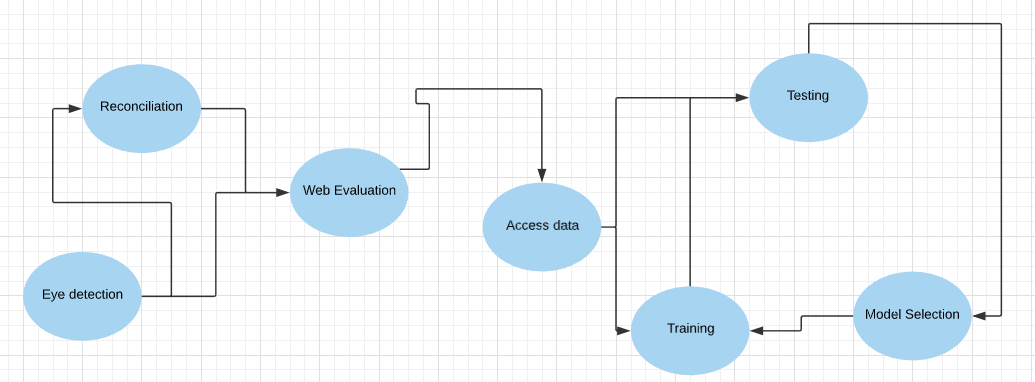

In [2]:
from IPython.display import Image as IpI
IpI("network.png")

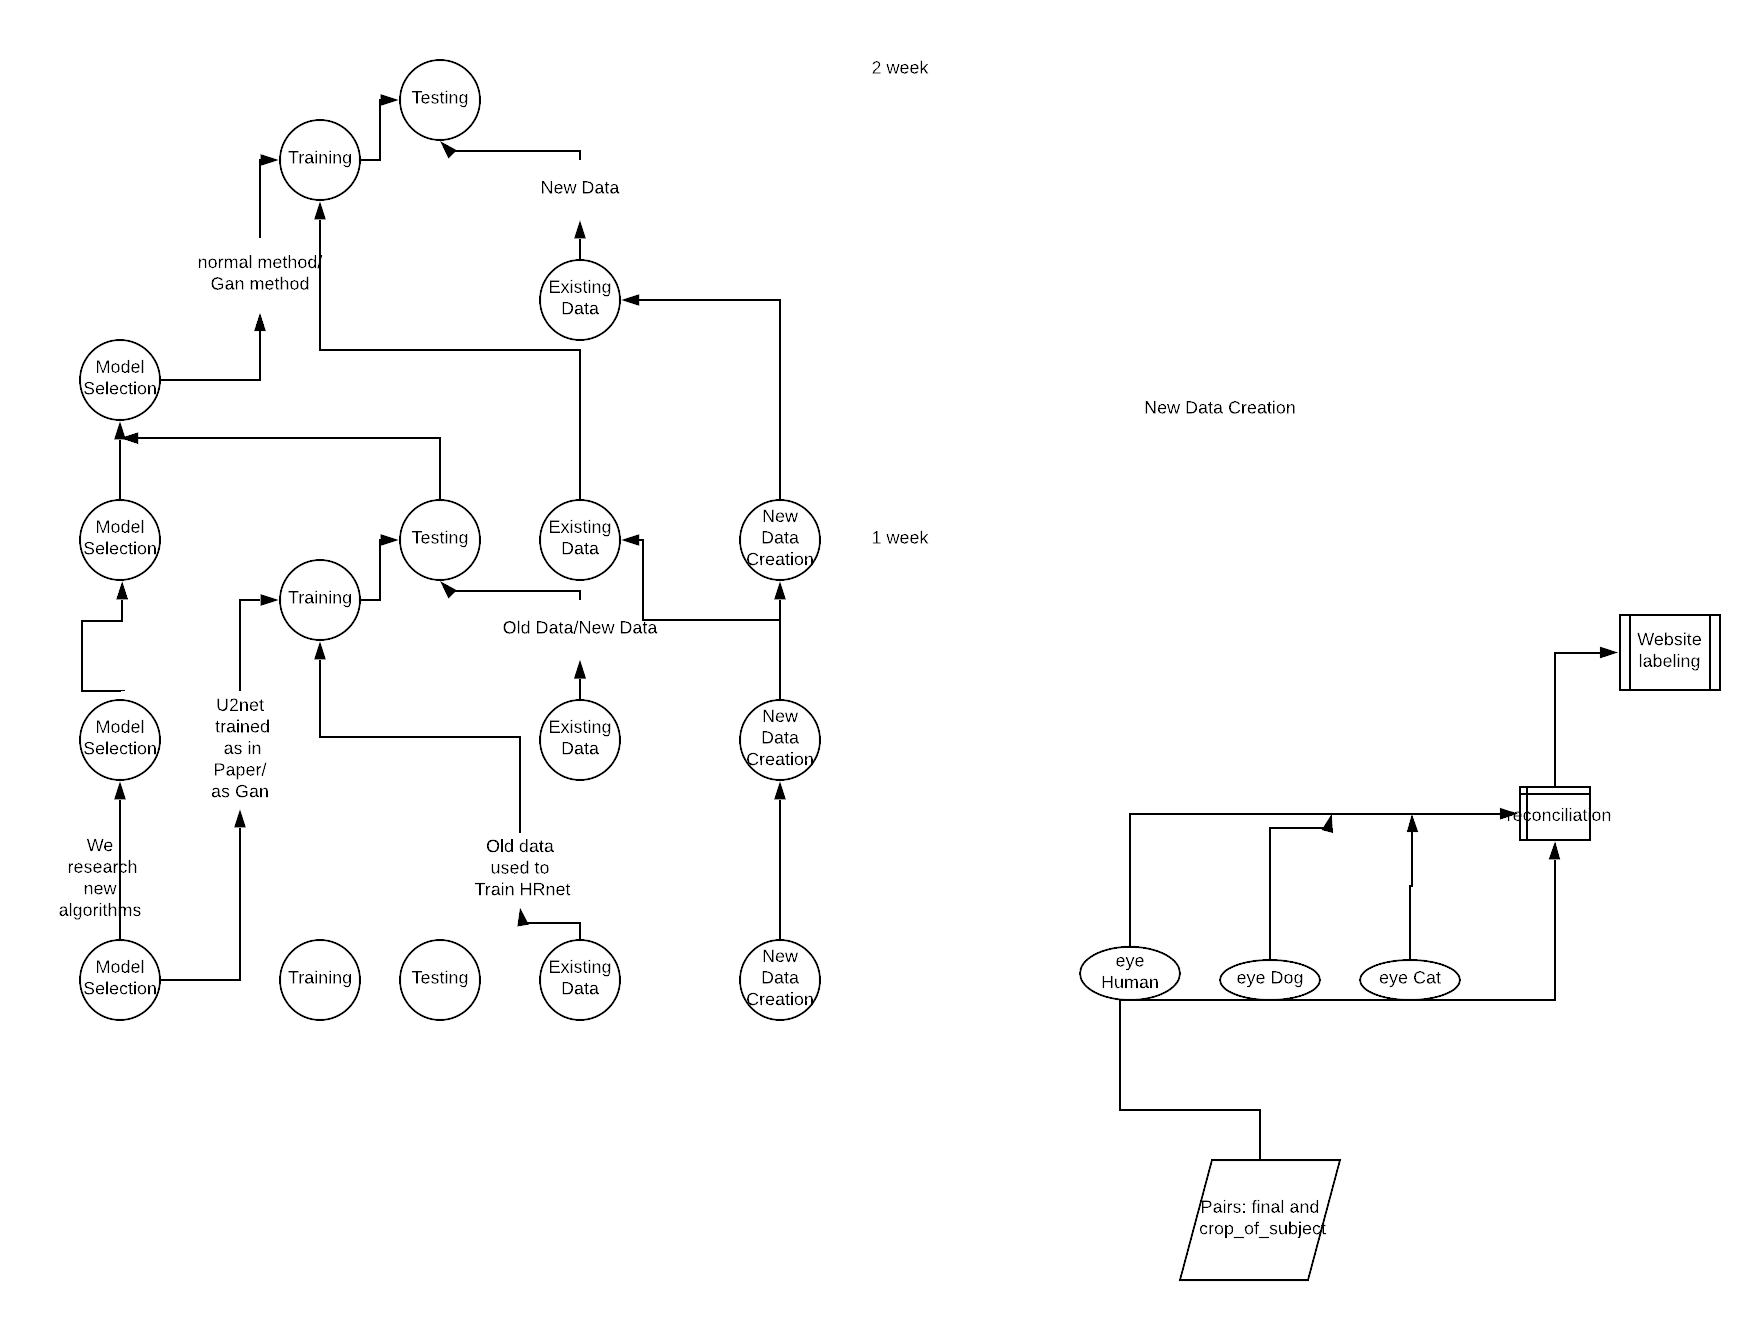

In [3]:

IpI("base_diagram.png")

In [ ]:
given a pair (input to automask, and final) we create 3 files:
    reconciliation with eyes
    nathan reconciliation
    eyes-nathan

In [4]:
import pandas as pd
# We have a csv of the masks that we labeled
db = pd.read_csv('mask_updates.csv')
# We need to find the crops needed 

In [5]:
db.head()

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
0,/refined_masks/mask_images3/mask_images2/14389...,20263,143893,good,dog,1
1,/refined_masks/mask_images3/mask_images2/14389...,20265,143895,good,dog,1
2,/refined_masks/mask_images3/mask_images2/14389...,20268,143896,good,dog,1
3,/refined_masks/mask_images3/mask_images2/14389...,20270,143897,bad,dog,1
4,/refined_masks/mask_images3/mask_images2/14390...,20273,143900,good,cat,1


In [6]:
db.describe()

,order_id,line_item_id,number_of_heads
count,3937.000000,3937.000000,3937.000000
mean,24259.324867,146798.887986,1.023622
std,2371.191404,1674.872935,0.185064
min,20263.000000,143893.000000,0.000000
25%,22237.000000,145346.000000,1.000000
50%,24246.000000,146831.000000,1.000000
75%,26250.000000,148249.000000,1.000000
max,42819.000000,149631.000000,4.000000


In [ ]:
What data we used to train HRnet?
mask_updates.csv has those mask that we labeled. Where is the corresponding file?  
It is a crop done on the original image.






In [9]:
list(db.mask_of_subjects_face[:5])

['/refined_masks/mask_images3/mask_images2/143893-20263-1539886090-84-1034e34e-75fe-4346-adc8-485ece94df1d.npy',
 '/refined_masks/mask_images3/mask_images2/143895-20265-1539834790-7-img-1144-01.npy',
 '/refined_masks/mask_images3/mask_images2/143896-20268-1539885630-90-img-0561.npy',
 '/refined_masks/mask_images3/mask_images2/143897-20270-1539886076-44-img-5953.npy',
 '/refined_masks/mask_images3/mask_images2/143900-20273-1539886709-49-linus.npy']

We take the first image, and we use the 	order_id	line_item_id	 to find the file divvyup-data/143893/20263/cropped

In [10]:
from PIL import Image
import numpy as np

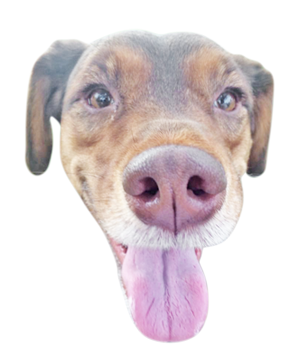

In [12]:
im = Image.open('figures/143893_20263_cropped_34781.png')
im

In [13]:
file = np.array(im)
file.shape

(350, 300, 4)

## This is a final image, not a crop

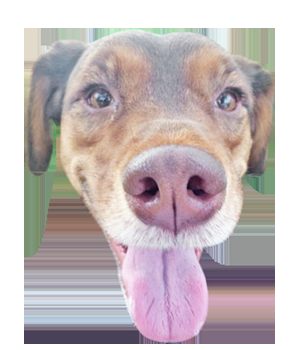

In [15]:
rgbfile=file[:,:,:3]
im2 = Image.fromarray(rgbfile)
im2

## This is an original image

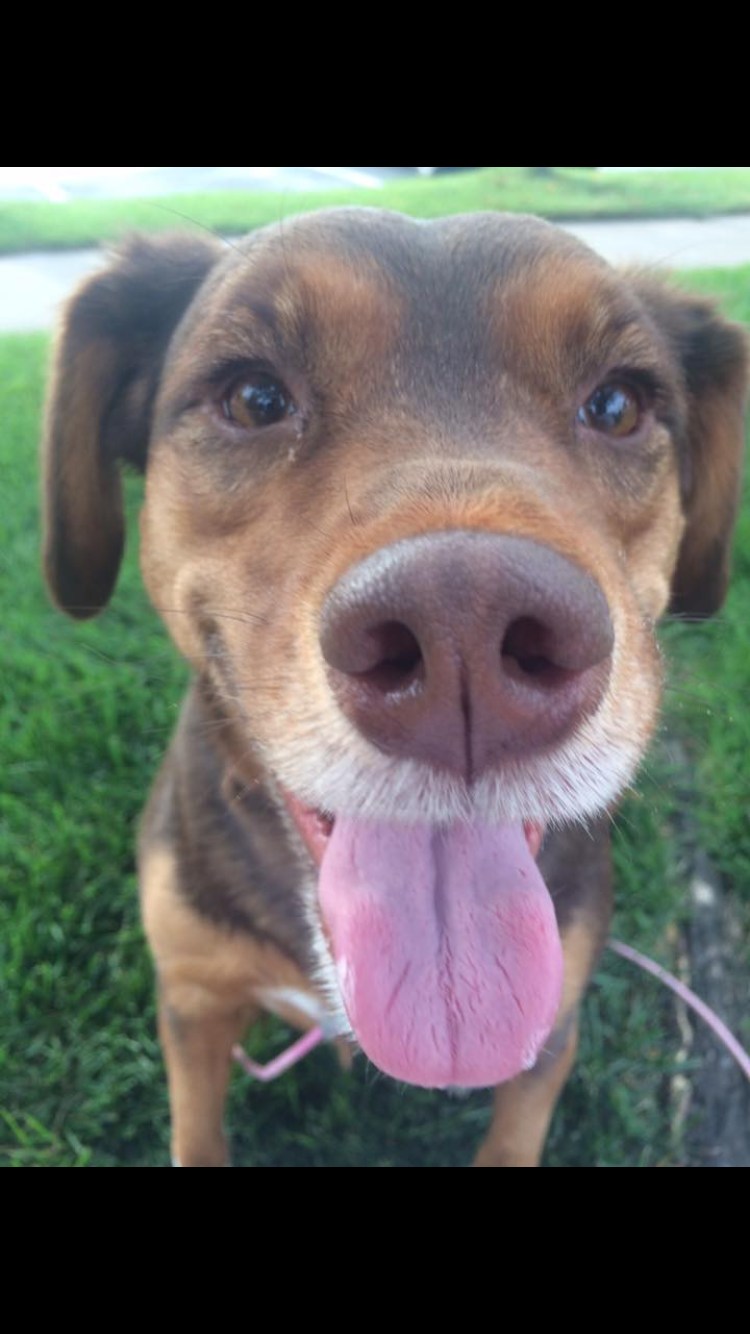

In [17]:
im3 = Image.open('figures/143893_1539886090-84-1034e34e-75fe-4346-adc8-485ece94df1d.png')
im3

In [18]:
file = np.array(im3)
file.shape

(1334, 750, 4)

### Where are the crops for the old data that we labeled?

### Once we have the data, we can train U2NET https://github.com/NathanUA/U-2-Net/blob/master/model/u2net.py 

# creation of new data

In [ ]:
## We have an algorithm to detect eyes

https://github.com/johnmath/Laser_Eye_Dogs for dogs,
https://github.com/NewSciTLH/rotation_human/blob/master/cloudFunction/main.py for humans

original detectors
https://github.com/kairess/cat_hipsterizer
https://github.com/kairess/dog_face_detector
google vision API

Working Plan.

Two paths.




In [ ]:
Our new dataset is sufficiently different from the training dataset that a model performing on the old dataset may fail in our dataset. 

While we build the new dataset, we prepare the models.

First we take the data used to train the original model, and use it on u2net. We need to modify u2net and 

    - Modify u2net to use all 6 of it's channels (1~2 days).
    - Find training data (ask Eric).
    -- Train directly u2net (1~week).
    -- Train with pix2pix (1-2~ weeks  ask Ericd)

In parallel:

    -Research newer methods including updates to hrnet and smaller versions.

- Test on data similar to training data
- Test on newer data.
    
Estimated time to have both models trained (1~2 weeks).

### Data collection.
The new dataset has less noise as the images are centered around the face.

- Pair the final product and the crop of subject
- Use google's landmark, dog landmark[https://github.com/kairess/dog_face_detector] and  cat landmark[https://github.com/kairess/cat_hipsterizer] to create a first reconciliation based only on eyes.
- If needed, run reconciliation algorithm only for small dilations, and rotations.
- While U2net is being trained, evaluate the datasets created. 
- Train U2net on the new dataset, adding new data and evaluating performace.







'divvyup-data/newsci_dump-02082019.json' contains a json with one to one and many to one images
gs://newsci-lab-data/divvyup-json/mask_updates.csv contains mask that were reconciled by us, and we can trust
    can we run a u2net on them?
    can we run a u2net on them with pix2pix?
    

In [1]:
import pandas as pd

file = pd.read_csv('mask_updates.csv')    

In [2]:
file.head()

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
0,/refined_masks/mask_images3/mask_images2/14389...,20263,143893,good,dog,1
1,/refined_masks/mask_images3/mask_images2/14389...,20265,143895,good,dog,1
2,/refined_masks/mask_images3/mask_images2/14389...,20268,143896,good,dog,1
3,/refined_masks/mask_images3/mask_images2/14389...,20270,143897,bad,dog,1
4,/refined_masks/mask_images3/mask_images2/14390...,20273,143900,good,cat,1


In [3]:
good = file[file.mask_quality=='good']

In [4]:
good.describe()

,order_id,line_item_id,number_of_heads
count,2825.000000,2825.000000,2825.000000
mean,24226.029735,146773.384071,1.014867
std,2372.631124,1666.266034,0.154461
min,20263.000000,143893.000000,0.000000
25%,22200.000000,145324.000000,1.000000
50%,24221.000000,146811.000000,1.000000
75%,26179.000000,148189.000000,1.000000
max,42819.000000,149631.000000,4.000000


In [5]:
good.head()

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
0,/refined_masks/mask_images3/mask_images2/14389...,20263,143893,good,dog,1
1,/refined_masks/mask_images3/mask_images2/14389...,20265,143895,good,dog,1
2,/refined_masks/mask_images3/mask_images2/14389...,20268,143896,good,dog,1
4,/refined_masks/mask_images3/mask_images2/14390...,20273,143900,good,cat,1
5,/refined_masks/mask_images3/mask_images2/14390...,20275,143902,good,human,1


In [7]:
good.mask_of_subjects_face[0]

'/refined_masks/mask_images3/mask_images2/143893-20263-1539886090-84-1034e34e-75fe-4346-adc8-485ece94df1d.npy'

### On divvyup-data/line/orderid/cropped we can find the rgb files.
We grab them and test u2net on it.

In [11]:
json = pd.read_json('newsci_dump-02082019.json', dtype=True)

In [12]:
json.head()

,numPhotos,numHeads,data
0,409354,424575,"{'order_id': 142372, 'line_items': [{'line_ite..."
1,409354,424575,"{'order_id': 142373, 'line_items': [{'line_ite..."
2,409354,424575,"{'order_id': 142374, 'line_items': [{'line_ite..."
3,409354,424575,"{'order_id': 142375, 'line_items': [{'line_ite..."
4,409354,424575,"{'order_id': 142377, 'line_items': [{'line_ite..."


In [13]:
json.data[0]

{'order_id': 142372,
 'line_items': [{'line_item_id': 18186,
   'original_photos': ['142372/1539646443-68-img-0299.jpg',
    '142372/1539646443-63-img-20150315-153534.jpg',
    '142372/1539646443-68-pippy.png'],
   'approved_cropped_heads': ['142372/18186/cropped/30871',
    '142372/18186/cropped/30872',
    '142372/18186/cropped/30873']},
  {'line_item_id': 18187,
   'original_photos': ['142372/1539647680-19-img-0299.jpg',
    '142372/1539647680-34-img-20150315-153534.jpg',
    '142372/1539647680-4-pippy.png'],
   'approved_cropped_heads': ['142372/18187/cropped/30875',
    '142372/18187/cropped/30876',
    '142372/18187/cropped/30878']}]}

In [43]:
import json
# load data using Python JSON module
with open('newsci_dump-02082019.json','r') as f:
    stuff = json.loads(f.read())
# Flatten data
df_nested_list = pd.json_normalize(stuff, record_path =['data','line_items'])# we ignore order id

In [44]:
df_nested_list.head()

,line_item_id,original_photos,approved_cropped_heads
0,18186,"[142372/1539646443-68-img-0299.jpg, 142372/153...","[142372/18186/cropped/30871, 142372/18186/crop..."
1,18187,"[142372/1539647680-19-img-0299.jpg, 142372/153...","[142372/18187/cropped/30875, 142372/18187/crop..."
2,18188,[142373/1539648052-25-e4876618-3ddb-4da2-905a-...,[142373/18188/cropped/30865]
3,18189,[142374/1539648041-56-d5fde5db-87c2-42b6-b06a-...,[142374/18189/cropped/30869]
4,18190,[142374/1539648124-93-815b6acc-1b65-4c4d-8ab9-...,[142374/18190/cropped/30870]


In [45]:
assert len(df_nested_list)== len(df_nested_list.line_item_id.unique() )

In [46]:
 len(df_nested_list)

304431

In [47]:
assert len(good)== len(good.line_item_id.unique() )

AssertionError: 

In [48]:
 len(good)

2825

In [49]:
len(good.line_item_id.unique() )

2239

In [50]:
good[good.duplicated(['line_item_id'], keep=False)]

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
8,/refined_masks/mask_images3/mask_images2/14390...,20281,143906,good,dog,1
9,/refined_masks/mask_images3/mask_images2/14390...,20282,143906,good,dog,1
10,/refined_masks/mask_images3/mask_images2/14390...,20283,143906,good,cat,1
20,/refined_masks/mask_images3/mask_images2/14392...,20305,143922,good,dog,1
21,/refined_masks/mask_images3/mask_images2/14392...,20306,143922,good,dog,1
...,...,...,...,...,...,...
3915,/refined_masks/mask_images3/mask_images2/14960...,28272,149608,good,dog,1
3916,/refined_masks/mask_images3/mask_images2/14960...,28273,149608,good,dog,1
3917,/refined_masks/mask_images3/mask_images2/14960...,28274,149608,good,dog,1
3918,/refined_masks/mask_images3/mask_images2/14960...,28275,149609,good,dog,1


I want to remove those terms that have more than one entry

In [51]:
new_table =pd.concat(g for _, g in good.groupby('line_item_id') if len(g) == 1)

In [52]:
len(new_table)

1824

This are the initial images to run experiments, they are already aligned, with a perfect label, and ready to be used.

In [54]:
joined = pd.merge(df_nested_list,new_table, on='line_item_id')

In [55]:
len(joined)

1795

In [56]:
joined.describe()

,line_item_id,order_id,number_of_heads
count,1795.000000,1795.000000,1795.000000
mean,146722.295265,24161.810028,1.018384
std,1664.364038,2398.358989,0.157307
min,143893.000000,20263.000000,0.000000
25%,145281.500000,22144.000000,1.000000
50%,146715.000000,24122.000000,1.000000
75%,148178.000000,26158.000000,1.000000
max,149631.000000,42819.000000,3.000000


In [57]:
joined.head()

,line_item_id,original_photos,approved_cropped_heads,mask_of_subjects_face,order_id,mask_quality,subject_class,number_of_heads
0,146351,[170972/1542721060-91-patches-chain.jpg],[170972/146351/cropped/350398],/refined_masks/mask_images3/mask_images2/14635...,23619,good,human,1
1,143893,[235511/1547332561-50-20190107-194519.jpg],[235511/143893/cropped/259883],/refined_masks/mask_images3/mask_images2/14389...,20263,good,dog,1
2,143896,[235514/1547332856-99-71c10db1-2c86-491e-9ccd-...,[235514/143896/cropped/258606],/refined_masks/mask_images3/mask_images2/14389...,20268,good,dog,1
3,143900,[235517/1547332808-63-9c1cce09-3889-499e-ae12-...,[235517/143900/cropped/259885],/refined_masks/mask_images3/mask_images2/14390...,20273,good,cat,1
4,143902,[235519/1547333284-1-2706910a-e8d1-4dde-8faf-5...,[235519/143902/cropped/258610],/refined_masks/mask_images3/mask_images2/14390...,20275,good,human,1


In [58]:
joined.to_csv('dataset.csv')